In [43]:
import time
start = time.perf_counter()

In [44]:
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import cross_val_score,  GridSearchCV, StratifiedShuffleSplit, learning_curve, validation_curve, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, auc, confusion_matrix, roc_curve, roc_auc_score, recall_score, f1_score, classification_report, precision_score, homogeneity_score, normalized_mutual_info_score, davies_bouldin_score, mean_squared_error, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.cluster import KMeans

In [45]:
np.random.seed(903967645)

In [46]:
default_payment_dataset = pd.read_csv('../data/default_of_credit_card_clients.csv', header=1)
print(default_payment_dataset.info())
default_payment_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [47]:
# Check shape of dataset and for null data
print(default_payment_dataset.shape)
default_payment_dataset.isna().any().any()
print(default_payment_dataset.columns)

(30000, 25)
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


In [48]:
default_payment_dataset = default_payment_dataset.sample(frac=1.0, random_state=42)

# Separate features and target
train_X = default_payment_dataset.drop(columns=['ID', 'default payment next month', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT6', 'BILL_AMT1', 'BILL_AMT2'])
train_y = default_payment_dataset['default payment next month']

# Normalize the feature data
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(train_X)

# Convert back to DataFrame
train_X = pd.DataFrame(X_scaled, columns=train_X.columns)
print(train_X.shape)

(30000, 18)


In [20]:
dims = list(range(2, 19, 1))

2 :  0.7207284720786831 0.06363927772363458
3 :  0.8175794926605617 0.06139055379877298
4 :  0.863536509639602 0.06032350625528687
5 :  0.9020908350225191 0.05942833722790265
6 :  0.930796381719037 0.05876184089936761
7 :  0.9523866821775568 0.058260549071007466
8 :  0.9654813042174903 0.057956513143546134
9 :  0.9743118963284589 0.057751481088836175
10 :  0.9808359489518135 0.05760000314742639
11 :  0.9870025533225749 0.05745682457583919
12 :  0.9913234555152393 0.05735650022118358
13 :  0.9943908301029559 0.05728528074842568
14 :  0.9967838009287698 0.0572297198393594
15 :  0.9981040393121706 0.05719906604117082
16 :  0.9989863836487041 0.057178579433929996
17 :  0.9996402004729492 0.05716339886560651
18 :  0.9999999999999997 0.057155044902990615


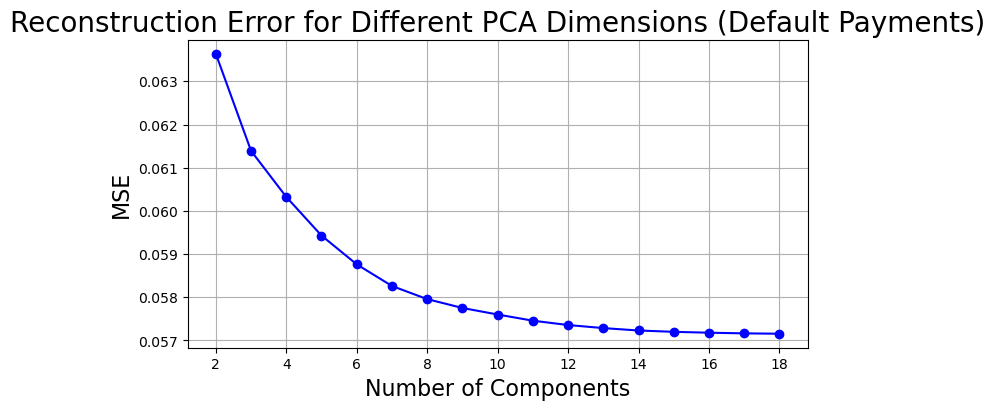

CPU times: user 2min 12s, sys: 29.1 s, total: 2min 41s
Wall time: 17.6 s


In [26]:
%%time

explained_variance_ratios = []
reconstruction_errors = []

for dim in dims:
    pca = PCA(n_components=dim, random_state=42)
    pca.fit(train_X.values)
    
    # PCA transformation
    x_prime = pca.transform(train_X.values)
    
    # Reconstruction
    A = np.linalg.pinv(pca.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(train_X.values, reconstructed)    
    
    explained_variance_ratios.append(sum(pca.explained_variance_ratio_))
    reconstruction_errors.append(rc_err)
    
    print(dim, ": ", sum(pca.explained_variance_ratio_), rc_err)

# Plotting reconstruction errors
plt.figure(figsize=(8, 4))
plt.plot(dims, reconstruction_errors, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Components", fontsize=16)
plt.ylabel("MSE", fontsize=16)
plt.title("Reconstruction Error for Different PCA Dimensions (Default Payments)", fontsize=20)
plt.savefig('../images/default-payments-psa-rmse.png')
plt.grid(True)
plt.show()

In [49]:
%%time
pca_optimal = 5
pca = PCA(n_components=pca_optimal, random_state=42)
pca_result = pca.fit_transform(train_X.values)
for i in range(pca_optimal):
    field_name = "pca-"+str(i)
    train_X[field_name] = pca_result[:,i]
    default_payment_dataset[field_name] = pca_result[:,i]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print(sum(pca.explained_variance_ratio_))
train_X_pca = pca_result
train_X_pca_df = pd.DataFrame(train_X_pca, columns=[f'pca-{i}' for i in range(pca_optimal)])

Explained variation per principal component: [0.57400414 0.14672433 0.09685102 0.04595702 0.03855433]
0.9020908350225191
CPU times: user 7.31 s, sys: 2.89 s, total: 10.2 s
Wall time: 1.07 s


In [50]:
eigenvalues = pca.explained_variance_

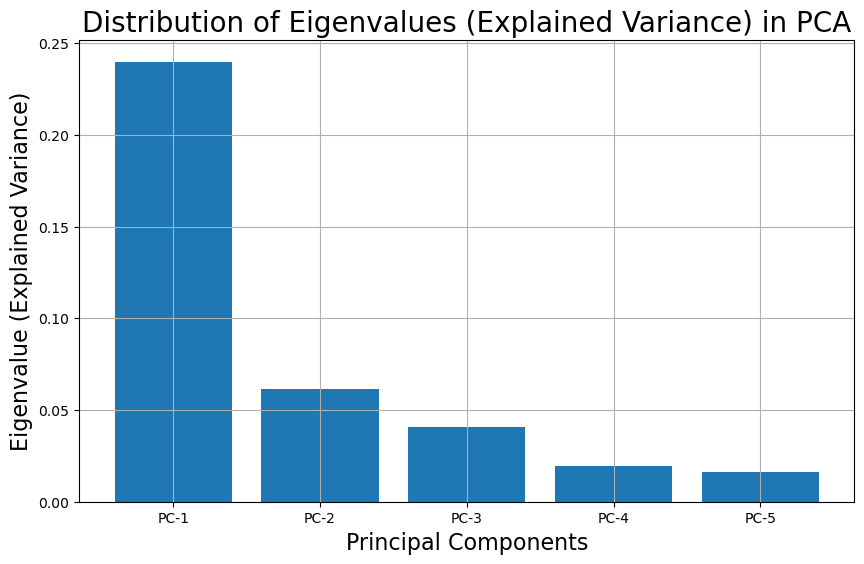

In [53]:
# Plot the eigenvalues
plt.figure(figsize=(10, 6))
plt.bar(range(len(eigenvalues)), eigenvalues, tick_label=[f'PC-{i+1}' for i in range(len(eigenvalues))])
plt.xlabel('Principal Components', fontsize=16)
plt.ylabel('Eigenvalue (Explained Variance)', fontsize=16)
plt.title('Distribution of Eigenvalues (Explained Variance) in PCA', fontsize=20)
plt.grid(True)
plt.savefig('../images/default-payments-pca-eignenvalues.png')
plt.show()

In [14]:
train_X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT5,PAY_AMT6,pca-0,pca-1,pca-2,pca-3,pca-4,pca-5,pca-6,pca-7
0,0.020202,0.0,0.333333,0.666667,0.068966,0.2,0.2,0.2,0.2,0.2,...,0.003517,0.003783,0.601110,0.064492,-0.243634,-0.129079,-0.026677,0.056837,0.027246,0.027957
1,0.141414,1.0,0.166667,0.666667,0.086207,0.2,0.2,0.2,0.2,0.2,...,0.006257,0.005049,-0.395206,0.100174,-0.215307,0.146697,-0.043629,-0.006102,-0.026386,0.093856
2,0.060606,1.0,0.500000,0.333333,0.189655,0.2,0.2,0.2,0.2,0.2,...,0.005861,0.004831,-0.396807,0.098535,0.145228,-0.114964,-0.027113,0.200590,0.019819,0.054951
3,0.121212,0.0,0.500000,0.666667,0.482759,0.2,0.2,0.2,0.2,0.2,...,0.016437,0.008338,0.611500,-0.016638,0.048595,-0.126993,0.293009,-0.052831,0.003932,-0.056142
4,0.040404,1.0,0.333333,0.666667,0.258621,0.2,0.2,0.2,0.2,0.2,...,0.000000,0.001892,-0.387672,0.172814,-0.095950,-0.056973,0.102649,-0.067029,0.086471,0.087689


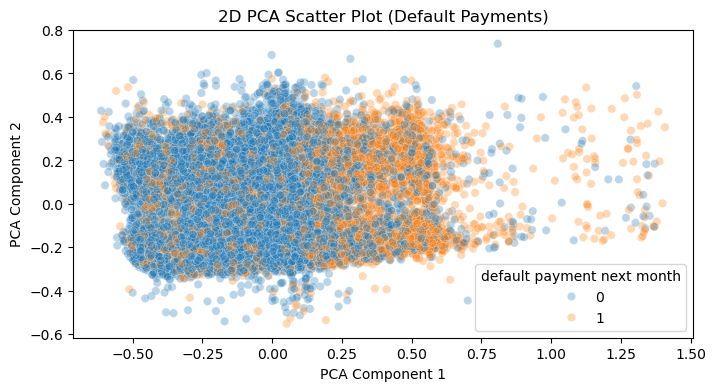

In [10]:
# Plotting the first two PCA components
plt.figure(figsize=(8, 4))
sns.scatterplot(
    x='pca-1', y='pca-2',
    hue='default payment next month',
    palette=sns.color_palette('tab10', 2),
    data=default_payment_dataset,
    legend='full',
    alpha=0.3
)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Scatter Plot (Default Payments)')
plt.savefig('../images/default-payments-nn-pca-2d.png')
plt.show()

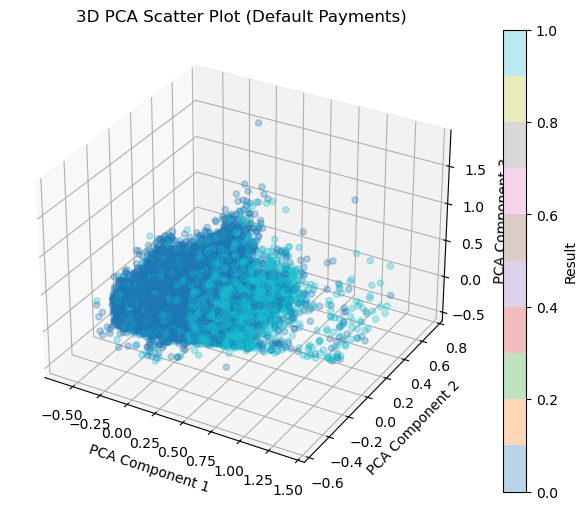

In [11]:
# Optional: 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    xs=default_payment_dataset["pca-1"], 
    ys=default_payment_dataset["pca-2"], 
    zs=default_payment_dataset["pca-3"], 
    c=default_payment_dataset["default payment next month"], 
    cmap='tab10',
    alpha=0.3
)
ax.set_xlabel('PCA Component 1', fontsize=16)
ax.set_ylabel('PCA Component 2',fontsize=16)
ax.set_zlabel('PCA Component 3', fontsize=16)
plt.colorbar(scatter, ax=ax, label='Result')
plt.title('3D PCA Scatter Plot (Default Payments)',fontsize=20)
fig.savefig('../images/default-payments-pca-3d.png')
plt.show()

# Clustering

For n_clusters=2, The Silhouette Coefficient is 0.5044402811455282
For n_clusters=2, The homogeneity_score is 8.951406029087967e-05
For n_clusters=3, The Silhouette Coefficient is 0.3229092494010976
For n_clusters=3, The homogeneity_score is 0.005070853789611029
For n_clusters=4, The Silhouette Coefficient is 0.33786751735532367
For n_clusters=4, The homogeneity_score is 0.004093859144886475
For n_clusters=5, The Silhouette Coefficient is 0.23329473565258677
For n_clusters=5, The homogeneity_score is 0.00969088002901764
For n_clusters=6, The Silhouette Coefficient is 0.24843327750060143
For n_clusters=6, The homogeneity_score is 0.01384555206241375
For n_clusters=7, The Silhouette Coefficient is 0.23771010896939432
For n_clusters=7, The homogeneity_score is 0.05059802234249018
For n_clusters=8, The Silhouette Coefficient is 0.22939133414166504
For n_clusters=8, The homogeneity_score is 0.04928439237961268
For n_clusters=9, The Silhouette Coefficient is 0.2239362191407043
For n_clusters

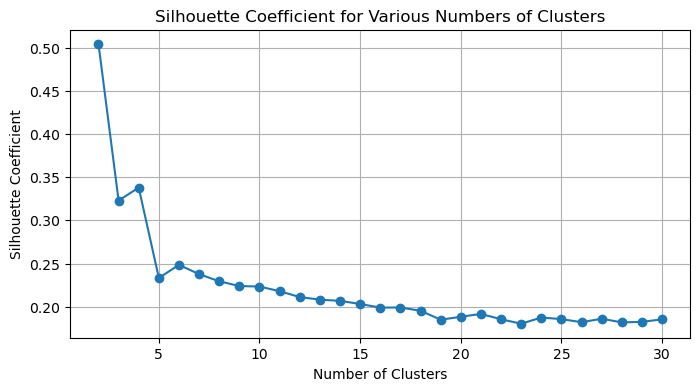

CPU times: user 7min 47s, sys: 8min 51s, total: 16min 38s
Wall time: 3min 26s


In [45]:
%%time
silhouette_coeffs_KM = {}
homogeneity_scores_KM = {}

for cluster in range(2, 31, 1):
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=42).fit(train_X_pca)
    label = kmeans.labels_
    sil_coeff = silhouette_score(train_X_pca, label, metric='euclidean')
    homog_score = homogeneity_score(train_y, label)
    silhouette_coeffs_KM[cluster] = sil_coeff
    homogeneity_scores_KM[cluster] = homog_score
    print(f"For n_clusters={cluster}, The Silhouette Coefficient is {sil_coeff}")
    print(f"For n_clusters={cluster}, The homogeneity_score is {homog_score}")
    
# Plotting Silhouette Coefficients
plt.figure(figsize=(8, 4))
plt.plot(list(silhouette_coeffs_KM.keys()), list(silhouette_coeffs_KM.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("KMeans - Silhouette Coefficient for Various Numbers of Clusters PCA (Default Payments)")
fig.savefig('../images/default-payments-pca-kmeans-silhouette.png')
plt.grid(True)
plt.show()

In [ ]:
# Plotting Silhouette Coefficient and Homogeneity Score
plt.figure(figsize=(8, 4))
plt.plot(list(silhouette_coeffs_KM.keys()), list(silhouette_coeffs_KM.values()), 'b', label='Silhouette Coefficient', marker='o')
plt.plot(list(homogeneity_scores_KM.keys()), list(homogeneity_scores_KM.values()), 'r', label='Homogeneity Score', marker='x')
plt.legend(loc='best')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Coefficient and Homogeneity Score for Various Numbers of Clusters PCA (Default Payments)')
plt.savefig('../images/default-payments-ica-kmeans-silhouette-and-homogeneity.png')
plt.grid(True)
plt.show()

In [ ]:
%%time
silhouette_coeffs_EM = {}
homogeneity_scores_EM = {}
log_likelihood_EM = {}

for cluster in range(2, 11, 1):
    gmm = GaussianMixture(n_components=cluster, n_init=10, max_iter=25, random_state=42).fit(train_X_pca)
    label = gmm.predict(train_X_pca)
    sil_coeff = silhouette_score(train_X_pca, label, metric='euclidean')
    homog_score = homogeneity_score(train_y, label)
    silhouette_coeffs_EM[cluster] = sil_coeff
    homogeneity_scores_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(train_X_pca)
    print(f"For n_clusters={cluster}, The Silhouette Coefficient is {sil_coeff}")
    print(f"For n_clusters={cluster}, The homogeneity_score is {homog_score}")
    print(f"For n_clusters={cluster}, The log_likeliehood score is {log_likelihood_EM[cluster]}")

    
# Plotting Silhouette Coefficients
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_coeffs.keys()), list(silhouette_coeffs.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("Expectation Maximization - PCA Silhouette Coefficient for Various Numbers of Clusters (Default Payments)")
plt.savefig('../images/default-payments-pca-em-silhouette-coefficients.png')
plt.grid(True)
plt.show()

For n_clusters=2, The Silhouette Coefficient is 0.5044402811455282
For n_clusters=2, The homogeneity_score is 8.951406029087967e-05
For n_clusters=2, The log_likeliehood score is 4.782781329508007
For n_clusters=3, The Silhouette Coefficient is 0.3042112539599692
For n_clusters=3, The homogeneity_score is 0.0006725054682944597
For n_clusters=3, The log_likeliehood score is 6.4458511443024324
For n_clusters=4, The Silhouette Coefficient is 0.007011396851412701
For n_clusters=4, The homogeneity_score is 0.0027217980890215858
For n_clusters=4, The log_likeliehood score is 8.46890528010459
For n_clusters=5, The Silhouette Coefficient is 0.11268194587701907
For n_clusters=5, The homogeneity_score is 0.03605503357874741
For n_clusters=5, The log_likeliehood score is 9.584289944736032


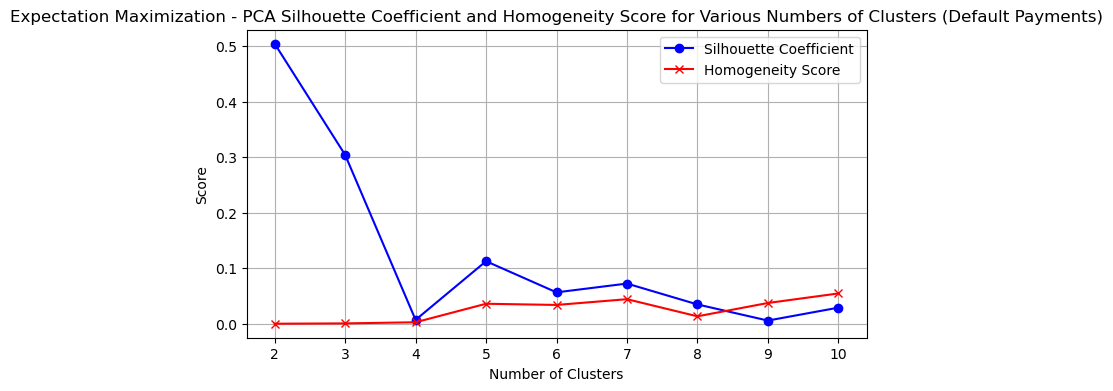

In [65]:
# Plotting Silhouette Coefficient and Homogeneity Score
plt.figure(figsize=(8, 4))
plt.plot(list(silhouette_coeffs_EM.keys()), list(silhouette_coeffs_EM.values()), 'b', label='Silhouette Coefficient', marker='o')
plt.plot(list(homogeneity_scores_EM.keys()), list(homogeneity_scores_EM.values()), 'r', label='Homogeneity Score', marker='x')
plt.legend(loc='best')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Expectation Maximization - PCA Silhouette Coefficient and Homogeneity Score for Various Numbers of Clusters (Default Payments)')
plt.savefig('../images/default-payments-rp-em-silhouette-homogeneity.png')
plt.grid(True)
plt.show()

In [32]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(train_X_pca)
kmeans_labels = kmeans.labels_

In [33]:
train_X['KMeans_Cluster'] = kmeans_labels

In [34]:
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(train_X_pca)
gmm_labels = gmm.predict(train_X_pca)

In [35]:
train_X['GMM_Cluster'] = gmm_labels
print(train_X_pca_df.head())

      pca-0     pca-1     pca-2     pca-3     pca-4
0  0.601783  0.083183 -0.230537 -0.115490 -0.075447
1 -0.396427  0.084701 -0.229723  0.094475 -0.026822
2 -0.397219  0.092651  0.148663 -0.159914 -0.137282
3  0.612041 -0.006885  0.057803 -0.184067  0.260191
4 -0.387794  0.177447 -0.088794 -0.069532  0.101601


In [39]:
features_to_plot = ['pca-1', 'pca-4']
# Get unique clusters for KMeans and GMM
unique_clusters_kmeans = np.unique(train_X['KMeans_Cluster'])
unique_clusters_gmm = np.unique(train_X['GMM_Cluster'])

NameError: name 'unique_clusters_kmeans' is not defined

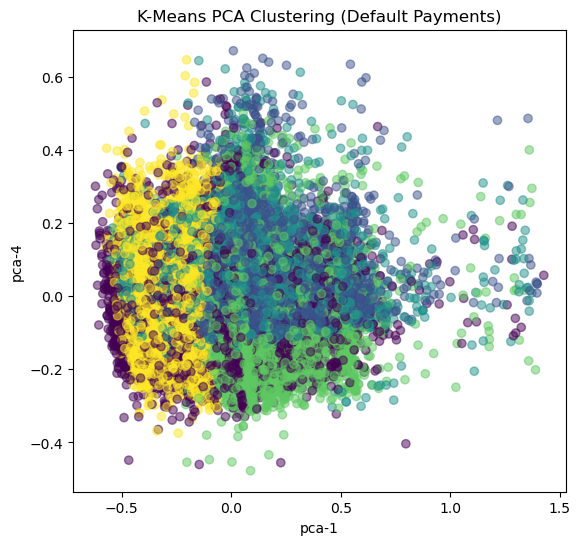

In [37]:
# Create a figure with subplots
plt.figure(figsize=(14, 6))

# Plot K-Means clustering results
plt.subplot(1, 2, 1)
scatter_kmeans = plt.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['KMeans_Cluster'], cmap='viridis', alpha=0.5)
plt.title('K-Means PCA Clustering (Default Payments)')
plt.xlabel(features_to_plot[0])
plt.ylabel(features_to_plot[1])
handles_kmeans = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_kmeans.cmap(scatter_kmeans.norm(cluster)), markersize=10) for cluster in unique_clusters_kmeans]
plt.legend(handles_kmeans, unique_clusters_kmeans, title='KMeans Cluster', loc='best')

# Plot GMM clustering results
plt.subplot(1, 2, 2)
scatter_gmm = plt.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
plt.title('EM PCA Clustering (Default Payments)')
plt.xlabel(features_to_plot[0])
plt.ylabel(features_to_plot[1])
handles_gmm = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_gmm.cmap(scatter_gmm.norm(cluster)), markersize=10) for cluster in unique_clusters_gmm]
plt.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

# Save the plot
plt.savefig('../images/default-payments-pca-clustering-comparison.png')

# Show the plot
plt.show()

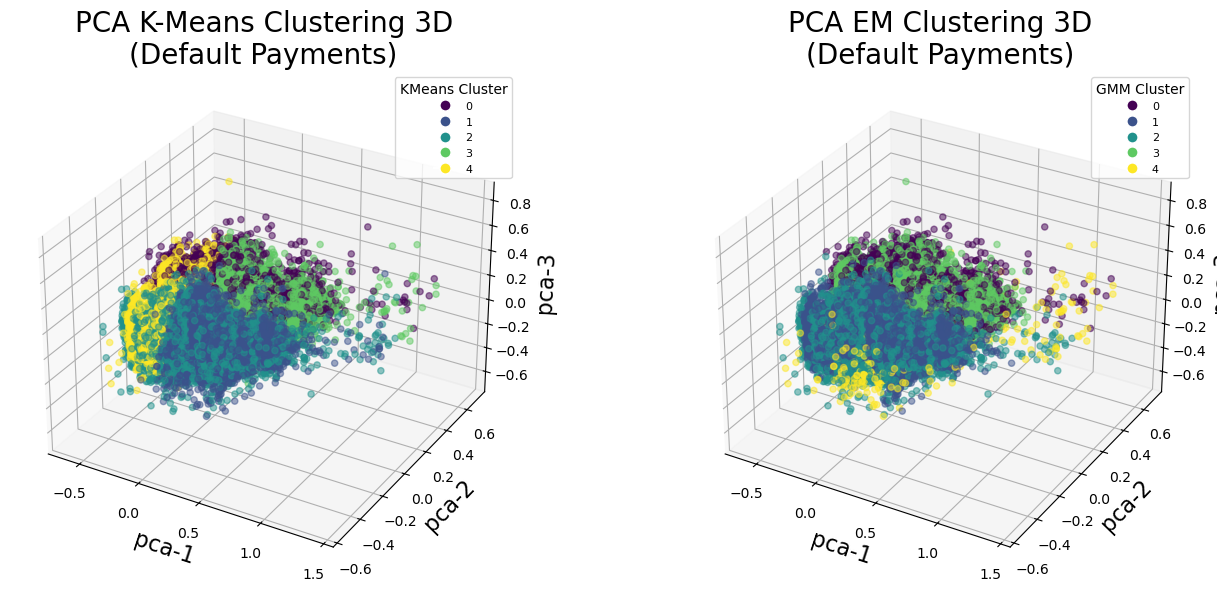

In [42]:
features_to_plot = ['pca-1', 'pca-4']

# Define the features you want to plot in 3D
features_to_plot_3d = ['pca-1', 'pca-2', 'pca-3']

# Create a figure for 2D K-Means and EM clustering results
fig_2d, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 2D Plot for K-Means clustering results
scatter_kmeans = ax1.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['KMeans_Cluster'], cmap='viridis', alpha=0.5)
ax1.set_title('PCA K-Means Clustering\n(Default Payments)', fontsize=12)
ax1.set_xlabel(features_to_plot[0], fontsize=10)
ax1.set_ylabel(features_to_plot[1], fontsize=10)
handles_kmeans = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_kmeans.cmap(scatter_kmeans.norm(cluster)), markersize=8) for cluster in unique_clusters_kmeans]
ax1.legend(handles_kmeans, unique_clusters_kmeans, title='KMeans Cluster', loc='best', fontsize=8, title_fontsize=10)

# 2D Plot for EM clustering results
scatter_gmm = ax2.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax2.set_title('PCA EM Clustering\n(Default Payments)', fontsize=12)
ax2.set_xlabel(features_to_plot[0], fontsize=10)
ax2.set_ylabel(features_to_plot[1], fontsize=10)
handles_gmm = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_gmm.cmap(scatter_gmm.norm(cluster)), markersize=8) for cluster in unique_clusters_gmm]
ax2.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best', fontsize=8, title_fontsize=10)

plt.tight_layout()
fig_2d.savefig('../images/default-payments-comparison-pca-2D.png', bbox_inches='tight', pad_inches=0.1)
plt.close(fig_2d)

# Create a figure for 3D K-Means and EM clustering results
fig_3d, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})

# 3D Plot for K-Means clustering results
scatter_kmeans_3d = ax1.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['KMeans_Cluster'], cmap='viridis', alpha=0.5)
ax1.set_title('PCA K-Means Clustering 3D\n(Default Payments)', fontsize=20)
ax1.set_xlabel(features_to_plot_3d[0], fontsize=16)
ax1.set_ylabel(features_to_plot_3d[1], fontsize=16)
ax1.set_zlabel(features_to_plot_3d[2], fontsize=16)
ax1.legend(handles_kmeans, unique_clusters_kmeans, title='KMeans Cluster', loc='best', fontsize=8, title_fontsize=10)

# 3D Plot for EM clustering results
scatter_gmm_3d = ax2.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax2.set_title('PCA EM Clustering 3D\n(Default Payments)', fontsize=20)
ax2.set_xlabel(features_to_plot_3d[0], fontsize=16)
ax2.set_ylabel(features_to_plot_3d[1], fontsize=16)
ax2.set_zlabel(features_to_plot_3d[2], fontsize=16)
ax2.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best', fontsize=8, title_fontsize=10)

plt.tight_layout()
fig_3d.savefig('../images/default-payments-comparison-pca-3D.png', bbox_inches='tight', pad_inches=0.1)
plt.show()
# plt.close(fig_3d)

In [31]:
# Calculate ARI
ari_score = adjusted_rand_score(train_X['KMeans_Cluster'], train_X['GMM_Cluster'])
print(f'Adjusted Rand Index (ARI) between KMeans and GMM clusters PCA: {ari_score}')

# Calculate NMI
nmi_score = normalized_mutual_info_score(train_X['KMeans_Cluster'], train_X['GMM_Cluster'])
print(f'Normalized Mutual Information (NMI) between KMeans and GMM clusters PCA: {nmi_score}')

Adjusted Rand Index (ARI) between KMeans and GMM clusters PCA: 0.6963421128512477
Normalized Mutual Information (NMI) between KMeans and GMM clusters PCA: 0.7706986680836744


# Neural Network

In [52]:
%%time

# Ensure train_X_grp and train_y are pandas DataFrames/Series
train_X_pca = pd.DataFrame(train_X_pca)
train_y = pd.Series(train_y)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(train_X_pca, train_y):
    strat_train_set = train_X_pca.iloc[train_index]
    strat_test_set = train_X_pca.iloc[test_index]
    strat_train_labels = train_y.iloc[train_index]
    strat_test_labels = train_y.iloc[test_index]

train_X_pca = strat_train_set
test_X_pca = strat_test_set
train_y = strat_train_labels
test_y = strat_test_labels

CPU times: user 13.2 ms, sys: 2.59 ms, total: 15.8 ms
Wall time: 13.1 ms


In [53]:
neural_net = MLPClassifier(random_state=42)
neural_net.fit(train_X_pca, train_y)

MLPClassifier(random_state=42)

In [54]:
%%time
# Evaluate on training data
train_predictions = neural_net.predict(train_X_pca)
train_accuracy = accuracy_score(train_y, train_predictions)
train_roc_auc = roc_auc_score(train_y, train_predictions)
train_precision = precision_score(train_y, train_predictions)
train_recall = recall_score(train_y, train_predictions)
train_f1 = f1_score(train_y, train_predictions)

print("Training Accuracy:", train_accuracy)
print("Training ROC AUC Score:", train_roc_auc)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1)
train_report = classification_report(train_y, train_predictions)
print(train_report)

# Write to a text file
with open('../results/default-payments-nn-pca-training_metrics_report.txt', 'w') as file:
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Training ROC AUC Score: " + str(train_roc_auc) + "\n")
    file.write("Training Precision: " + str(train_precision) + "\n")
    file.write("Training Recall: " + str(train_recall) + "\n")
    file.write("Training F1 Score: " + str(train_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(train_report + "\n")

Training Accuracy: 0.8120833333333334
Training ROC AUC Score: 0.6601425011190358
Training Precision: 0.620440156768164
Training Recall: 0.38764362403465813
Training F1 Score: 0.47716206816600976
              precision    recall  f1-score   support

           0       0.84      0.93      0.89     18691
           1       0.62      0.39      0.48      5309

    accuracy                           0.81     24000
   macro avg       0.73      0.66      0.68     24000
weighted avg       0.79      0.81      0.80     24000

CPU times: user 266 ms, sys: 331 ms, total: 597 ms
Wall time: 64.5 ms


In [55]:
%%time
# Evaluate testing data
test_predictions = neural_net.predict(test_X_pca)
test_accuracy = accuracy_score(test_y, test_predictions)
test_roc_auc = roc_auc_score(test_y, test_predictions)
test_precision = precision_score(test_y, test_predictions)
test_recall = recall_score(test_y, test_predictions)
test_f1 = f1_score(test_y, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing ROC AUC Score:", test_roc_auc)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)
print("Testing F1 Score:", test_f1)
test_report = classification_report(test_y, test_predictions)
print(test_report)

# Write to a text file
with open('../results/default-payments-nn-pca-testing_metrics_report.txt', 'w') as file:
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Testing ROC AUC Score: " + str(test_roc_auc) + "\n")
    file.write("Testing Precision: " + str(test_precision) + "\n")
    file.write("Testing Recall: " + str(test_recall) + "\n")
    file.write("Testing F1 Score: " + str(test_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(test_report + "\n")

Testing Accuracy: 0.8063333333333333
Testing ROC AUC Score: 0.6514714958109655
Testing Precision: 0.599758162031439
Testing Recall: 0.373775433308214
Testing F1 Score: 0.4605385329619313
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4673
           1       0.60      0.37      0.46      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

CPU times: user 139 ms, sys: 84.9 ms, total: 224 ms
Wall time: 25.9 ms


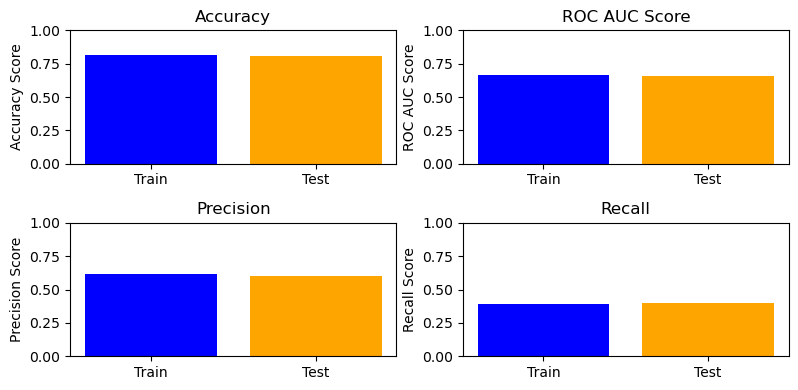

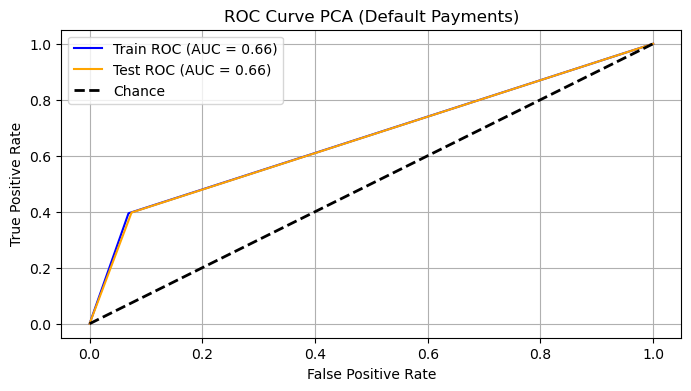

CPU times: user 769 ms, sys: 15.2 ms, total: 784 ms
Wall time: 281 ms


In [104]:
%%time
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

# Accuracy
ax[0, 0].bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel('Accuracy Score')

# ROC AUC Score
ax[0, 1].bar(['Train', 'Test'], [train_roc_auc, test_roc_auc], color=['blue', 'orange'])
ax[0, 1].set_title('ROC AUC Score')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_ylabel('ROC AUC Score')

# Precision
ax[1, 0].bar(['Train', 'Test'], [train_precision, test_precision], color=['blue', 'orange'])
ax[1, 0].set_title('Precision')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_ylabel('Precision Score')

# Recall
ax[1, 1].bar(['Train', 'Test'], [train_recall, test_recall], color=['blue', 'orange'])
ax[1, 1].set_title('Recall')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_ylabel('Recall Score')

plt.tight_layout()
fig.savefig('../images/default-payments-nn-pca-metrics-comparison.png')
plt.show()

# Plotting  ROC Curves
train_fpr, train_tpr, _ = roc_curve(train_y, train_predictions)
test_fpr, test_tpr, _ = roc_curve(test_y, test_predictions)

plt.figure(figsize=(8, 4))
plt.plot(train_fpr, train_tpr, label=f'Train ROC (AUC = {auc(train_fpr, train_tpr):.2f})', color='blue')
plt.plot(test_fpr, test_tpr, label=f'Test ROC (AUC = {auc(test_fpr, test_tpr):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve PCA (Default Payments)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/default-payments-nn-pca-roc-curve')
plt.show()

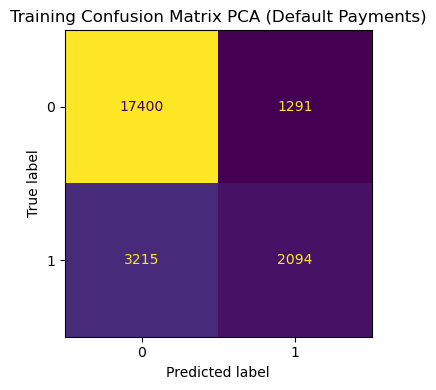

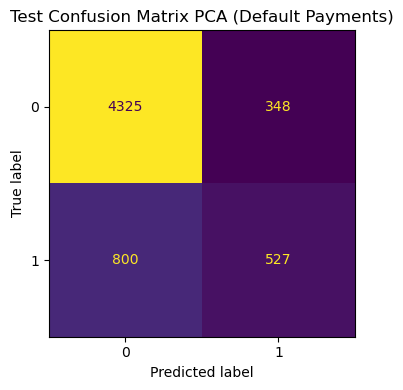

CPU times: user 380 ms, sys: 12.6 ms, total: 393 ms
Wall time: 142 ms


In [107]:
%%time
# Plot and save Training Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
train_cm = confusion_matrix(train_y, train_predictions)
ConfusionMatrixDisplay(train_cm).plot(ax=ax, colorbar=False)
ax.set_title("Training Confusion Matrix PCA (Default Payments)")
plt.tight_layout()
plt.savefig('../images/default-payments-nn-pca-training-cm.png')
plt.show()

# Plot and save Test Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
test_cm = confusion_matrix(test_y, test_predictions)
ConfusionMatrixDisplay(test_cm).plot(ax=ax, colorbar=False)
ax.set_title('Test Confusion Matrix PCA (Default Payments)')
plt.tight_layout()
plt.savefig('../images/default-payments-nn-pca-testing-cm.png')
plt.show()

Training progress:   0%|                                                                                                                                                                     | 0/10 [00:00<?, ?it/s]/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn'

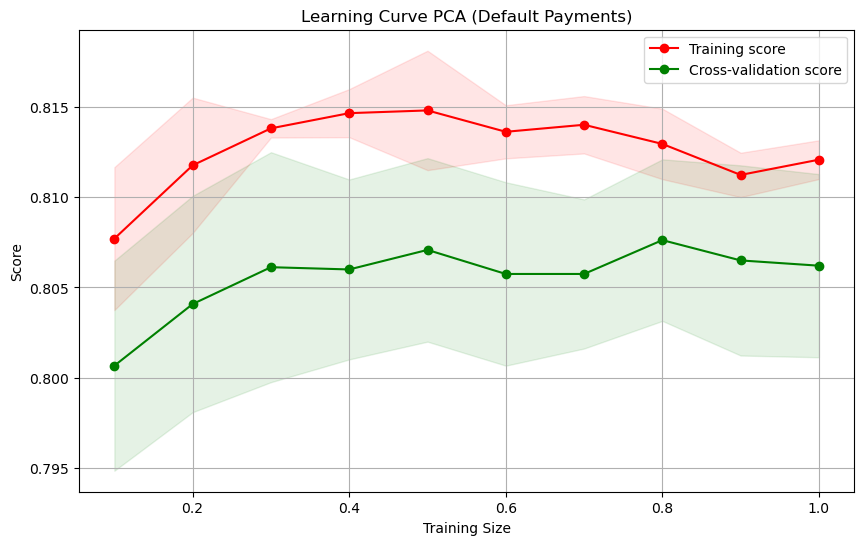

CPU times: user 22min 58s, sys: 54 s, total: 23min 52s
Wall time: 2min 30s


In [111]:
%%time
# Create a wrapper function for learning_curve to show progress
def learning_curve_with_progress(estimator, X, y, cv, scoring, train_sizes):
    all_train_scores = []
    all_test_scores = []
    for train_size in tqdm(train_sizes, desc='Training progress'):
        _, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=[train_size], cv=cv, scoring=scoring)
        all_train_scores.append(train_scores)
        all_test_scores.append(test_scores)
    return train_sizes, np.array(all_train_scores).squeeze(), np.array(all_test_scores).squeeze()

train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve_with_progress(neural_net, train_X_pca, train_y, cv=5, scoring='accuracy', train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve PCA (Default Payments)')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/default-payments-nn-pca-learning-curve-training-size.png')
plt.show()

Validation progress:   0%|                                                                                                                                                                    | 0/3 [00:00<?, ?it/s]/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Validation progress:  33%|████████████████████████████████████████████████████                                                                                                        | 1/3 [00:04<00:08,  4.02s/it]/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Validation progress: 100%|██

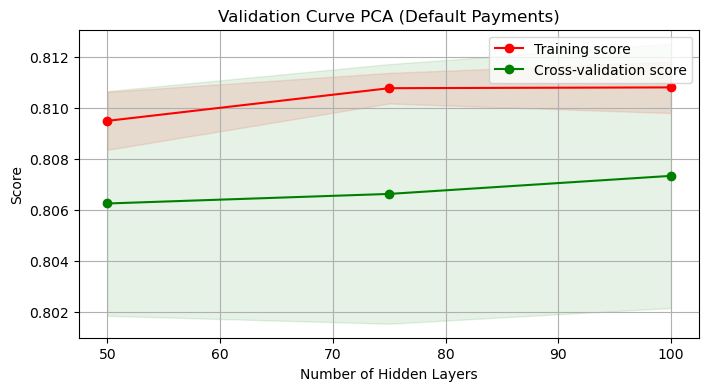

CPU times: user 809 ms, sys: 725 ms, total: 1.53 s
Wall time: 12.3 s


In [112]:
%%time
param_range = [50, 75, 100]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

train_scores, test_scores = validation_curve_with_progress(MLPClassifier(), train_X_pca, train_y, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Validation Curve PCA (Default Payments)')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/default-payments-nn-pca-validation-curve-hidden-layers.png')
plt.show()

Validation progress:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 3/6 [00:07<00:08,  2.91s/it]/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Validation progress:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 5/6 [00:20<00:05,  5.06s/it]/Users/xavierelon/miniconda3

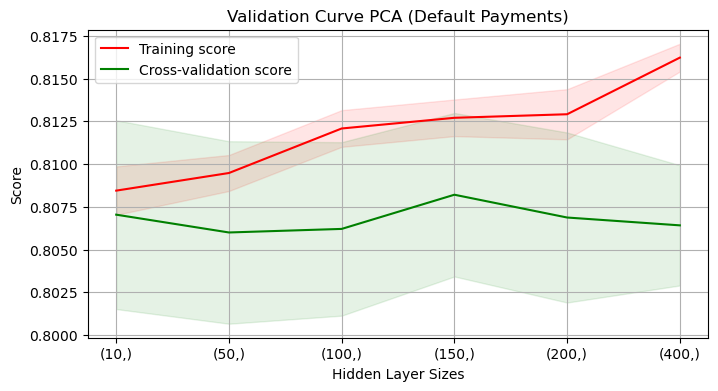

CPU times: user 368 ms, sys: 76.1 ms, total: 444 ms
Wall time: 33.5 s


In [114]:
%%time
# Define the range for the hyperparameter hidden_layer_sizes
param_range = [(10,), (50,), (100,), (150,), (200,), (400,)]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(random_state=42), train_X_pca, train_y, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot([str(x) for x in param_range], train_scores_mean, label="Training score", color="r")
plt.plot([str(x) for x in param_range], test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between([str(x) for x in param_range], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between([str(x) for x in param_range], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve PCA (Default Payments)")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-pca-validation-curve-hidden-layer-sizes-2.png')
plt.show()

Validation progress:  20%|██████████████▊                                                           | 1/5 [00:05<00:21,  5.32s/it]/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Validation progress: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.26s/it]


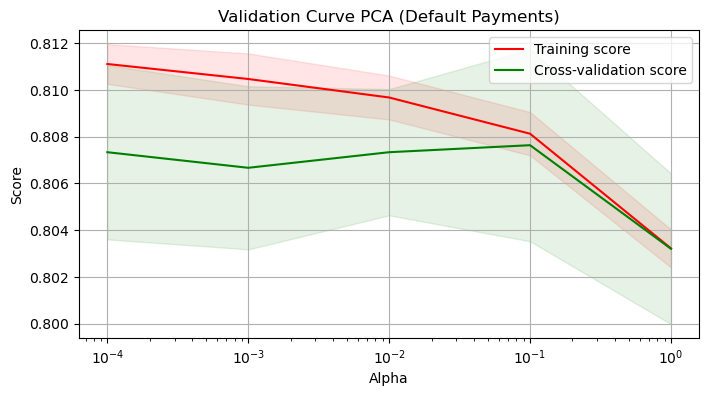

CPU times: user 801 ms, sys: 1.9 s, total: 2.7 s
Wall time: 16.7 s


In [20]:
%%time
# Define the range for the hyperparameter alpha
param_range = [0.0001, 0.001, 0.01, 0.1, 1]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(hidden_layer_sizes=(100,), random_state=42), train_X_pca, train_y, param_name="alpha", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve PCA (Default Payments)")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.xscale('log')  # Use a logarithmic scale for alpha
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-pca-validation-curve-alpha.png')
plt.show()

In [116]:
%%time
# Perform 10-fold cross-validation
cv_scores = cross_val_score(neural_net, train_X_pca, train_y, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("mean cross-validation score:", cv_scores.mean())

# Write cross-validation scores to a text file
with open('../results/default-payments-nn-pca-cross_validation_scores.txt', 'w') as file:
    file.write("Cross-validation scores: " + np.array2string(cv_scores) + "\n")
    file.write("Mean cross-validation score: " + str(cv_scores.mean()) + "\n")

/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

Cross-validation scores: [0.80375    0.81875    0.81041667 0.80833333 0.80083333 0.8
 0.81166667 0.81333333 0.80625    0.81375   ]
mean cross-validation score: 0.8087083333333334
CPU times: user 10min 4s, sys: 30.9 s, total: 10min 35s
Wall time: 1min 7s


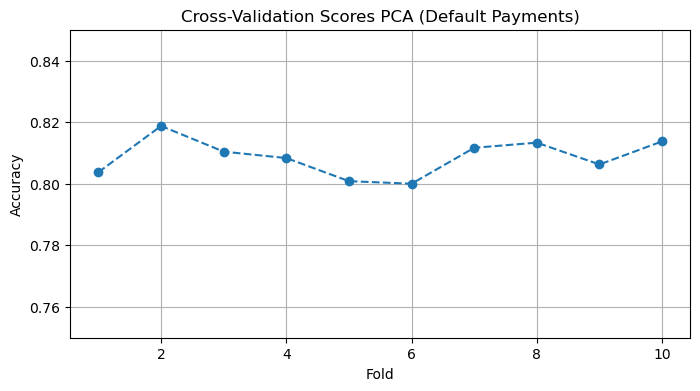

In [117]:
# Plot cross-validation scores
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='--')
plt.title('Cross-Validation Scores PCA (Default Payments)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0.75, .85])
plt.grid(True)
plt.savefig('../images/default-payments-nn-pca-cross-validation-scores.png')
plt.show()

/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

              precision    recall  f1-score   support

           0       0.84      0.93      0.88     18691
           1       0.61      0.38      0.47      5309

    accuracy                           0.81     24000
   macro avg       0.72      0.66      0.68     24000
weighted avg       0.79      0.81      0.79     24000



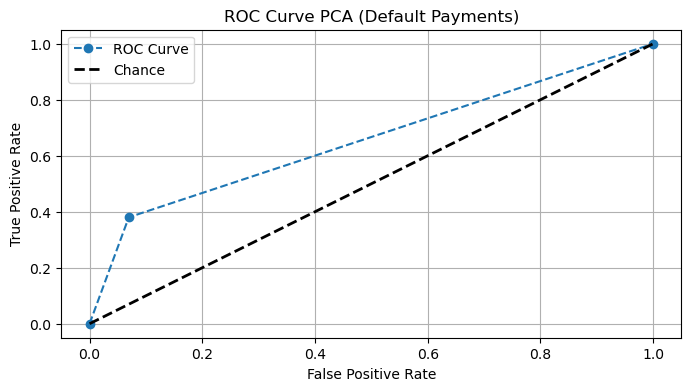

CPU times: user 9min 23s, sys: 26.7 s, total: 9min 49s
Wall time: 1min 1s


In [118]:
%%time
y_pred = cross_val_predict(neural_net, train_X_pca, train_y, cv=10)

report = classification_report(train_y, y_pred)
print(report)

with open('../results/default-payments-nn-rp-classification_report.txt', 'w') as file:
    file.write(report)
    
fpr, tpr, thresholds = roc_curve(train_y, y_pred, pos_label=1)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, marker='o', linestyle='--', label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve PCA (Default Payments)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/default-payments-nn-pca-roc-curve-fpr.png')
plt.show()

/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

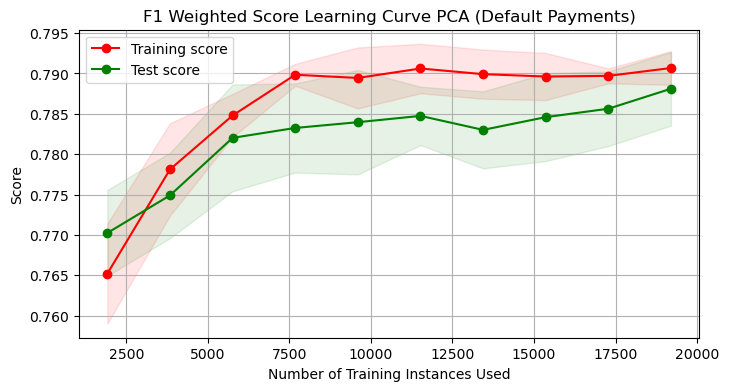

CPU times: user 619 ms, sys: 275 ms, total: 894 ms
Wall time: 7.75 s


In [119]:
%%time
best_mlp = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    hidden_layer_sizes=(100,),
    learning_rate='adaptive',
    max_iter=100,
    solver='adam'
)

# Assuming best_mlp, train_X, train_y are already defined
train_sizes, train_scores, test_scores = learning_curve(
    best_mlp, train_X_pca, train_y, cv=5, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

plt.title('F1 Weighted Score Learning Curve PCA (Default Payments)')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-pca-best-nn-training-vs-test-set')
plt.show()
# Write to a text file
with open('../results/default-payments-nn-pca-test_classification_results.txt', 'w') as file:
    file.write("Classification Report:\n")
    file.write(test_report + "\n")
    file.write("Confusion Matrix:\n")
    file.write(np.array2string(test_cm) + "\n")

In [120]:
end = time.perf_counter()
print("Time taken: in min", (end - start)/60)

Time taken: in min 88.24976627848325
